# Random Walk

Let's suppose we have a random walk process defined by
$$
x(t+1) = x(t) + 2 \varepsilon - 1, \; \; \; \; \varepsilon \sim \mathrm{Bernoulli}(p)
$$
where $p$ is the probability of doing a step forward.

In this notebook, we create some synthetic data for a value of $p$ and we try to recover it through inference.

In [1]:
from blackbirds.models.random_walk import RandomWalk
from blackbirds.infer.vi import VI
from blackbirds.posterior_estimators import TrainableGaussian
from blackbirds.simulate import simulate_and_observe_model

import torch
import matplotlib.pyplot as plt
import pandas as pd

## Generating synthetic data

In [2]:
rw = RandomWalk(n_timesteps=100)

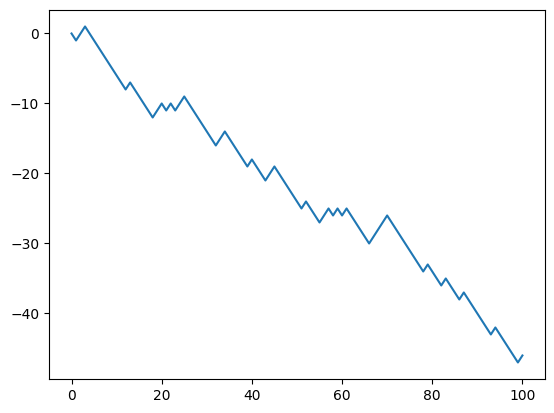

In [3]:
true_p = torch.logit(torch.tensor(0.25))
true_data = rw.observe(rw.run(torch.tensor([true_p])))

plt.plot(true_data[0].numpy())

## Defining the loss

The loss callable needs to take as input the model parameters and true data and return the loss value.

In [4]:
class L2Loss:
    def __init__(self, model):
        self.model = model
        self.loss_fn = torch.nn.MSELoss()
    def __call__(self, params, data):
        observed_outputs = simulate_and_observe_model(self.model, params)
        return self.loss_fn(observed_outputs[0], data[0])

In [5]:
posterior_estimator = TrainableGaussian([0.], 1.0)
prior = torch.distributions.Normal(true_p + 0.2, 1)
optimizer = torch.optim.Adam(posterior_estimator.parameters(), 1e-2)
loss = L2Loss(rw)

vi = VI(loss, posterior_estimator=posterior_estimator, prior=prior, optimizer=optimizer, w = 0)

In [6]:
# we can now train the estimator for a 100 epochs
vi.run(true_data, 1000, max_epochs_without_improvement=100)

 24%|█████████████████▉                                                        | 243/1000 [00:47<02:28,  5.09it/s, loss=29.2, reg.=0, total=29.2, best loss=19.8, epochs since improv.=100]


The model stops when it hits a certain amount of epochs without improvement.
The run function returns the loss per epoch as well as the best model weights.
Let's have a look at the loss first:

In [7]:
df = pd.DataFrame(vi.losses_hist)
df.head()

,total,loss,regularisation
0,1800.693115,1800.693115,0.0
1,942.427734,942.427734,0.0
2,1702.843506,1702.843506,0.0
3,2089.033691,2089.033691,0.0
4,2143.318848,2143.318848,0.0


<Axes: >

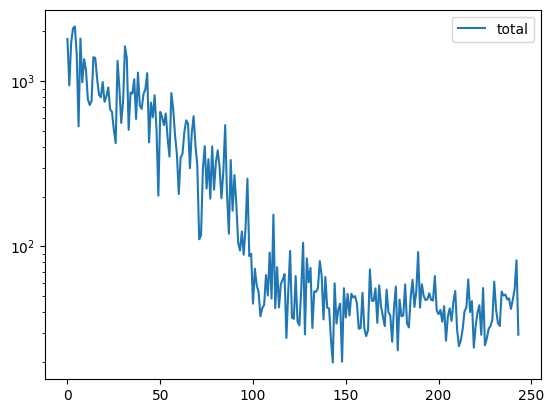

In [8]:
df.plot(y="total", logy=True)

In [9]:
# We can now load the best model
posterior_estimator.load_state_dict(vi.best_estimator_state_dict)

<All keys matched successfully>

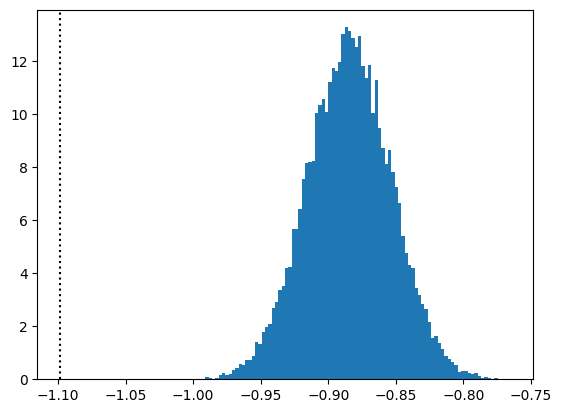

In [10]:
# and plot the posterior
with torch.no_grad():
    samples = posterior_estimator.sample(20000)[0].flatten().cpu()
plt.hist(samples, density=True, bins=100);
plt.axvline(true_p, label = "true value", color = "black", linestyle=":")

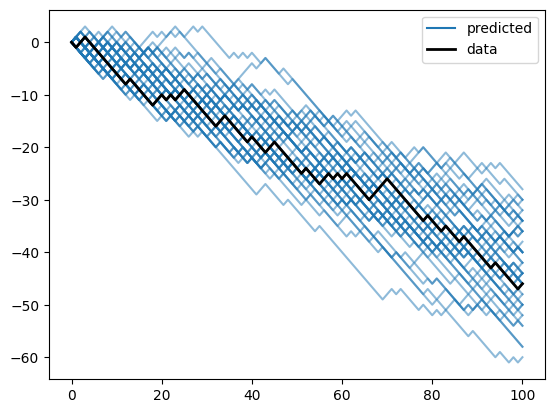

In [11]:
# compare the predictions to the synthetic data:

f, ax = plt.subplots()

for i in range(50):
    with torch.no_grad():
        sim_rw = rw.observe(rw.run(posterior_estimator.sample(1)[0]))[0].numpy()
    ax.plot(sim_rw, color = "C0", alpha=0.5)
    
ax.plot([], [], color = "C0", label = "predicted")
ax.plot(true_data[0], color = "black", linewidth=2, label = "data")

ax.legend()